This notebook is a narrative exploration of efforts to predict the number of citations per year a paper will receive,
based on data available at time of publication.

A full exploration of 25 different prediction models can be found [here](askfhs)

In this notebook I look to predict the number of citations a paper will received based upon
* the words used in the abstract
* physics-inspired semantic metrics (implemented in github.com/zhafen/cc and employed in Imel & Hafen in prep)
* metadata (publishing journal, number of authors, number of pages, etc.)

The raw code for this analysis can be [found here](https://github.com/zhafen/work-sample).

I aimed to keep this work sample clean, so please reach out if you have questions about details I have not included.

You can jump to punchlines in the analysis via these links:

# User-Defined Parameters

This dictionary contains various user-defined parameters. They will be explained when they are utilized.

In [24]:
pm = dict(
    # Data
    data_dir = '/Users/zhafen/data/literature_topography',
    region_number = 8,
    convergence_degree = 3,
    kernel_size = 16,
    # Features
    numerical_variables = [
        'age',
        'converged_kernel_size',
        'density',
        'fringe_factor',
        'references_count',
        'page_count',
        'log_author_count',
    ],
    categorical_variables = [
        'journal_filtered',
    ],
    semantic_variables = [
        'density',
        'fringe_factor',
    ]
)

# Data

I use publication abstracts and metadata pulled from the [NASA astrophysics data sytem](https://ui.adsabs.harvard.edu) via [the official API](https://ui.adsabs.harvard.edu/help/api/). The analyzed publications are from a randomly-chosen physics or astrophysics specialization.

I externally preprocessed the abstract data with natural language processing (including tokenizing, stemming, and removing filler words), and each abstract has a corresponding bag-of-words representation.

## Load raw data

In [32]:
import numpy as np
import os

In [26]:
# My custom non-relational-data-management package
import verdict
# My library for NLP analysis of scientific abstracts
from cc import atlas, cartography, utils

In [16]:
# Load summary information.
# I analyzed several randomly chosen specializations ("regions"), of which we are choosing an arbitrary one.
summary_data_fp = os.path.join( pm['data_dir'], 'regions', 'regions_summary.h5' )
data = verdict.Dict.from_hdf5( summary_data_fp )
data_k = data['regions'][str(pm['region_number'])]

In [18]:
# Class for management of abstracts
atlas_dir = os.path.join( pm['data_dir'], 'regions', 'region_{}'.format( pm['region_number'] ) )
a = atlas.Atlas( atlas_dir, load_bibtex=False )

Loading saved atlas data.


0it [00:00, ?it/s]
100%|█████████████████████████████████| 37311/37311 [00:01<00:00, 21616.01it/s]


In [19]:
# Class for analysis of vectorized abstracts
projection = a.vectorize(
    verbose = True,
)
c = cartography.Cartographer( **projection )

Vectorizing text...
Using saved vectorized text...


In [23]:
# Retrieve metrics I calculated in external pre-processing
metrics_fp = os.path.join( atlas_dir, 'topography_metrics.h5' )
metrics = verdict.Dict.from_hdf5( metrics_fp )

In [27]:
# Not all the publications are viable for analysis.
# I've saved information about what publications are viable, and here we load the identifying information.
converged_kernel_size = data_k['converged_kernel_size'][:,-pm['convergence_degree']]
converged = converged_kernel_size >= pm['kernel_size']
publications = c.publications[converged]
inds = np.arange( c.publications.size )[converged]

In [29]:
# Select word vectors
v = c.vectors[inds]

## Format into a DataFrame

In [37]:
import copy
import pandas as pd
import warnings

In [54]:
# Make into a dataframe, for convenience.
df_data = copy.deepcopy( metrics )
df_data['projection_ind'] = inds
df = pd.DataFrame(
    data = df_data._storage,
    index=publications,
)

In [55]:
# Drop publications with no citations.
# This catches all grant submissions, etc.
df = df.loc[np.invert( np.isclose( df['citations_per_year'], 0. ) )]

In [56]:
# Add logscale versions for some variables
for column in [ 'density', 'citations_per_year', ]:
    df['log_{}'.format( column )] = np.log10( df[column] )

## Derive or retrieve additional quantities

In [61]:
import tqdm

### ADS metadata

In [62]:
citation_keys = []
additional_data = {
    'references_count': [],
    'pages': [],
    'author': [],
    'journal': [],
    'title': [],
    'abstract_character_count': [],
    'entry_date': [],
}
for citation_key, p in tqdm.tqdm( a.data.items() ):
    
    citation_keys.append( citation_key )
    
    # number of references
    if p.references is None:
        additional_data['references_count'].append( 0 )
    else:
        additional_data['references_count'].append( len( p.references ) )
    
    # Citation info
    for key in [ 'pages', 'author', 'journal', 'title' ]:
        try:
            additional_data[key].append( p.citation[key] )
        except KeyError:
            additional_data[key].append( pd.NA )
            
    # Abstract
    additional_data['abstract_character_count'].append( len( p.abstract_str() ) )
    
    # Entry date
    additional_data['entry_date'].append( p.entry_date )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37311/37311 [00:02<00:00, 18022.32it/s]


In [63]:
# Convert to datetime
additional_data['entry_date'] = pd.to_datetime( additional_data['entry_date'] )

In [66]:
# Join it onto the existing dataframe
additional_df = pd.DataFrame( data=additional_data, index=citation_keys )
df = df.join( additional_df )

### Index

In [67]:
df['ind'] = np.arange( df.index.size )

### Page count

In [68]:
# Setup data structurs
df['page_count'] = np.full( len( df ), np.nan )

In [69]:
# Get rid of the "L" in front of the pages for publications submitted to letters.
pages_str = df['pages'].str.replace( 'L|P', '' )

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_36366/1933168570.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pages_str = df['pages'].str.replace( 'L|P', '' )


In [70]:
# Split into two to take the difference
pages_split = pages_str.str.split( '-', expand=True )

In [71]:
# Identify the parseable data
is_not_none = np.invert( pages_split[1].isnull() )
is_numeric = pages_split[1].str.isnumeric()
is_page_range = is_not_none & is_numeric

In [72]:
# For the valid page ranges, set the page count
df.loc[is_page_range,'page_count'] = (
    pages_split[1].loc[is_page_range].astype( int )
    - pages_split[0].loc[is_page_range].astype( int )
)

In [93]:
# There can be one or two edge cases where there's a negative page count because of the formatting
df.loc[df['page_count']<0,'page_count'] = np.nan

### Author count

In [73]:
df['author_count'] = df['author'].str.split( ' and ' ).apply( len )
df['log_author_count'] = df['author_count'].apply( np.log10 )

### Title character count

In [74]:
df['title_character_count'] = df['title'].str.len()

### Journals, filtered

In [75]:
# Find the most common journals
df_grouped = df.groupby( 'journal' )
journal_entry_count = df_grouped.size().sort_values( ascending=False )
most_common_journals = journal_entry_count.iloc[:5].index

In [76]:
most_common_journals

Index(['\apj', '\mnras', '\aap', '\aj', '\apjl'], dtype='object', name='journal')

In [77]:
# Make a new column accordingly
df['journal_filtered'] = df['journal'].copy()
is_not_common_journal = np.invert( df['journal'].isin( most_common_journals ) )
df.loc[is_not_common_journal,'journal_filtered'] = 'other'
df.loc[df['journal'].isna(),'journal_filtered'] = 'other'

### Word vectors

In [134]:
v = c.vectors[df['projection_ind']]

## Summarize data

There are two main data containers:
`df`, which contains all the metadata and derived quantities,
and `v`, which contains the word vectors.

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7380 entries, 2004JMOp...51.1447V to 1972ApJ...175L..73S
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   age                        7380 non-null   float64            
 1   citations_per_year         7380 non-null   float64            
 2   converged_kernel_size      7380 non-null   int32              
 3   density                    7359 non-null   float64            
 4   fringe_factor              7359 non-null   float64            
 5   kernel_constant_asymmetry  7359 non-null   float64            
 6   smoothing_length           7359 non-null   float64            
 7   projection_ind             7380 non-null   int64              
 8   log_density                7359 non-null   float64            
 9   log_citations_per_year     7380 non-null   float64            
 10  references_count           7380 non-null   i

In [79]:
df.head()

,age,citations_per_year,converged_kernel_size,density,fringe_factor,kernel_constant_asymmetry,smoothing_length,projection_ind,log_density,log_citations_per_year,...,journal,title,abstract_character_count,entry_date,ind,page_count,author_count,log_author_count,title_character_count,journal_filtered
2004JMOp...51.1447V,18.033916,2.495301,22,13.197566,0.679266,10.868260,1.212345,2,1.120494,0.397123,...,Journal of Modern Optics,{Ultrafast superconducting single-photon detec...,1173,2005-05-11 00:00:00+00:00,0,11.0,13,1.113943,103,other
2002MNRAS.336.1129B,20.556883,1.070202,57,13.189905,0.694470,11.111526,1.213049,3,1.120242,0.029466,...,\mnras,{STJ observations of the eclipsing polar HU Aqr},1063,2002-11-02 00:00:00+00:00,1,9.0,9,0.954243,48,\mnras
2002OptEn..41.1170V,20.855476,0.671287,56,13.394224,0.696136,11.138178,1.194545,4,1.126918,-0.173092,...,Optical Engineering,{Superconducting tunnel junctions as photon-co...,1532,2002-07-16 00:00:00+00:00,2,14.0,5,0.698970,110,other
2001MNRAS.324..899P,21.784125,1.606676,23,13.020577,0.660474,10.567585,1.228824,5,1.114630,0.205928,...,\mnras,{High-speed energy-resolved STJ photometry of ...,1523,2001-08-11 00:00:00+00:00,3,10.0,7,0.845098,74,\mnras
1999MNRAS.309..379W,23.531848,1.614834,79,13.100298,0.671835,10.749364,1.221346,7,1.117281,0.208128,...,\mnras,{The seeing at the William Herschel Telescope},512,1999-11-12 00:00:00+00:00,4,8.0,4,0.602060,46,\mnras


In [137]:
v.shape

(7380, 30286)

## Split testing and training data

In [80]:
from sklearn.model_selection import train_test_split

In [127]:
# Split dataframe
df_train, df_test = train_test_split( df, test_size=0.2, random_state=42 )

In [126]:
# Split input
X_train = df_train[pm['numerical_variables'] + pm['categorical_variables']].values
X_test = df_test[pm['numerical_variables'] + pm['categorical_variables']].values

In [82]:
# Split word vector input
v_train = v[df_train['ind']]
v_test = v[df_test['ind']]

In [129]:
# Split output
y_train = df_train['log_citations_per_year'].values
y_test = df_test['log_citations_per_year'].values

In [128]:
# Split semantic input
S_train = df_train[pm['semantic_variables']].values
S_test = df_test[pm['semantic_variables']].values

# Exploratory Data Analysis

I've explored this dataset thoroughly elsewhere, so here I'll just visually summarize the dataset.

In [84]:
import seaborn as sns

sns.set_style( 'whitegrid' )

## Citations per year

<AxesSubplot: xlabel='log_citations_per_year', ylabel='Count'>

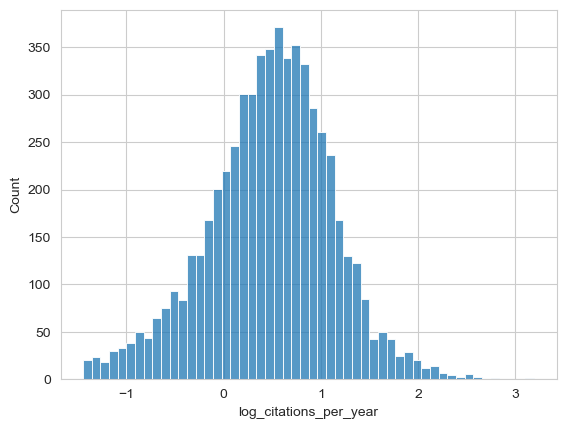

In [112]:
sns.histplot(
    df_train,
    x = 'log_citations_per_year',
)

## Numerical variables

(0.0, 40.0)

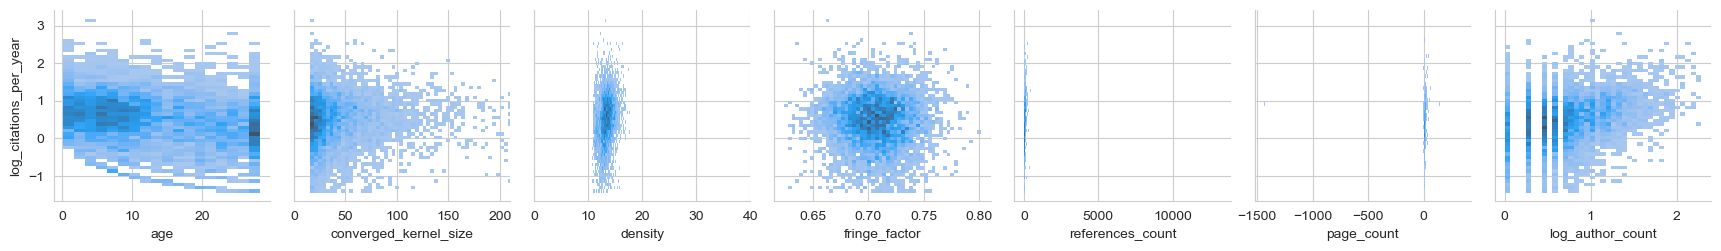

In [111]:
pairplot = sns.pairplot(
    df_train,
    x_vars = pm['numerical_variables'],
    y_vars = [ 'log_citations_per_year',],
    kind = 'hist',
    # plot_kws = { 'line_kws': { 'color': 'k', }, },
)
pairplot.axes[0,1].set_xlim( 0, 210 )
pairplot.axes[0,2].set_xlim( 0, 40 )

## Categorical variable

<AxesSubplot: xlabel='journal_filtered', ylabel='log_citations_per_year'>

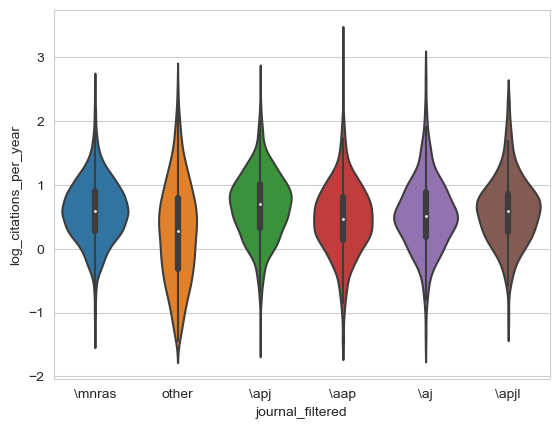

In [114]:
sns.violinplot(
    df_train,
    x = 'journal_filtered',
    y = 'log_citations_per_year',
)

# Model Construction

## Preprocessing

In [117]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [118]:
# Two things for our numerical variables:
# Imputation of missing values and scaling by mean and std
numerical_preprocessing = Pipeline(
    [
        ( 'impute', SimpleImputer( strategy='mean' ) ),
        ( 'scale', StandardScaler() ),
    ]
)

In [121]:
# Combine the numerical preprocessing with onehot encoding for the categorical variable
preprocessing = ColumnTransformer( [
        ( 'numerical', numerical_preprocessing, pm['numerical_variables'] ),
        ( 'onehot', OneHotEncoder(), pm['categorical_variables'] ),
] )

In [122]:
# Preprocessing for word vectors is just scaling
vector_preprocessing = Pipeline(
    [
        ( 'scale', Normalizer() ),
    ]
)

In [123]:
# There is a subset of the numerical variables that I refer to as "semantic".
# These variables contain metrics that measure the relationship of the words in a publication to words in other publications.
semantic_preprocessing = Pipeline(
    [
        ( 'scale', StandardScaler() ),
    ]
)

# Cross Validation

In [282]:
from sklearn.model_selection import cross_validate

In [ ]:
cross_validate(
    estimator = model,
    X = x_t_df.values,
    y = df_train['log_citations_per_year'].values,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
)

{'fit_time': array([0.0011487 , 0.00084901, 0.00049782, 0.000458  , 0.00043535]),
 'score_time': array([0.00037026, 0.00032496, 0.00028419, 0.00027323, 0.00028801]),
 'estimator': [Baseline(), Baseline(), Baseline(), Baseline(), Baseline()],
 'test_score': array([-0.42891344, -0.42412764, -0.38014943, -0.41732149, -0.44537275])}

# Takeaways

* Even the best model can't predict citations that well. Our minimum RMSE suggests we will routinely misestimate by a factor of X

# Credits

Utilized python packages include:
* [ads](https://github.com/andycasey/ads)
* nltk